In [ ]:
%tensorflow_version 1.x

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
A = tf.placeholder(tf.float32, shape=(5, 5), name='A')
v = tf.placeholder(tf.float32)
w = tf.matmul(A, v)

In [ ]:
with tf.Session() as session:
   output = session.run(w, feed_dict={A: np.random.randn(5, 5), v: np.random.randn(5, 1)})
   print(output, type(output))

[[ 0.48268625]
 [-0.7590695 ]
 [ 1.7777084 ]
 [-1.1147269 ]
 [ 0.9343786 ]] <class 'numpy.ndarray'>


In [ ]:
shape = (2, 2)
x = tf.Variable(tf.random_normal(shape))
# x = tf.Variable(np.random.randn(2, 2))
t = tf.Variable(0)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as session:
    out = session.run(init) # and then "run" the init operation
    print(out) # it's just None

    # eval() in tf is like get_value() in Theano
    print(x.eval()) # the initial value of x
    print(t.eval())

In [ ]:
u = tf.Variable(20.0)
cost = u*u + u + 1.0

In [ ]:
train_op = tf.train.GradientDescentOptimizer(0.3).minimize(cost)

# let's run a session again
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as session:
    session.run(init)

    # Strangely, while the weight update is automated, the loop itself is not.
    # So we'll just call train_op until convergence.
    # This is useful for us anyway since we want to track the cost function.
    for i in range(12):
        session.run(train_op)
        print("i = %d, cost = %.3f, u = %.3f" % (i, cost.eval(), u.eval()))

i = 0, cost = 67.990, u = 7.700
i = 1, cost = 11.508, u = 2.780
i = 2, cost = 2.471, u = 0.812
i = 3, cost = 1.025, u = 0.025
i = 4, cost = 0.794, u = -0.290
i = 5, cost = 0.757, u = -0.416
i = 6, cost = 0.751, u = -0.466
i = 7, cost = 0.750, u = -0.487
i = 8, cost = 0.750, u = -0.495
i = 9, cost = 0.750, u = -0.498
i = 10, cost = 0.750, u = -0.499
i = 11, cost = 0.750, u = -0.500


Building the basicx neural network using tensorflow

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd


def get_normalized_data():
    print("Reading in and transforming data...")

    # if not os.path.exists('../large_files/train.csv'):
    #     print('Looking for ../large_files/train.csv')
    #     print('You have not downloaded the data and/or not placed the files in the correct location.')
    #     print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
    #     print('Place train.csv in the folder large_files adjacent to the class folder')
    #     exit()

    df = pd.read_csv('/content/sample_data/mnist_train_small.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]
    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std
    
    return Xtrain, Xtest, Ytrain, Ytest

In [ ]:

def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [ ]:
def error_rate(p, t):
    return np.mean(p != t)


Reading in and transforming data...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Cost / err at iteration i=0, j=0: 2293.684 / 0.808
Cost / err at iteration i=1, j=0: 477.426 / 0.132
Cost / err at iteration i=2, j=0: 306.440 / 0.093
Cost / err at iteration i=3, j=0: 253.498 / 0.085
Cost / err at iteration i=4, j=0: 221.368 / 0.071
Cost / err at iteration i=5, j=0: 199.308 / 0.064
Cost / err at iteration i=6, j=0: 183.227 / 0.055
Cost / err at iteration i=7, j=0: 171.117 / 0.050
Cost / err at iteration i=8, j=0: 162.703 / 0.052
Cost / err at iteration i=9, j=0: 156.316 / 0.049
Cost / err at iteration i=10, j=0: 151.685 / 0.048
Cost / err at iteration i=11, j=0: 148.569 / 0.049
Cost / err at iteration i=12, j=0: 146.950 / 0.047
Cost / err at iteration i=13, j=0: 146.198 / 0.046
Cost / err at iteration i=14, j=0: 146.672 / 0.046


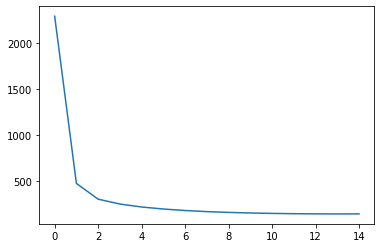

In [ ]:
def main():
    # step 1: get the data and define all the usual variables
    Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

    max_iter = 15
    print_period = 50

    lr = 0.00004
    reg = 0.01

    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)

    N, D = Xtrain.shape
    batch_sz = 500
    n_batches = N // batch_sz

    # add an extra layer just for fun
    M1 = 300
    M2 = 100
    K = 10
    W1_init = np.random.randn(D, M1) / np.sqrt(D)
    b1_init = np.zeros(M1)
    W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
    b2_init = np.zeros(M2)
    W3_init = np.random.randn(M2, K) / np.sqrt(M2)
    b3_init = np.zeros(K)


    # define variables and expressions
    X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    T = tf.placeholder(tf.float32, shape=(None, K), name='T')
    W1 = tf.Variable(W1_init.astype(np.float32))
    b1 = tf.Variable(b1_init.astype(np.float32))
    W2 = tf.Variable(W2_init.astype(np.float32))
    b2 = tf.Variable(b2_init.astype(np.float32))
    W3 = tf.Variable(W3_init.astype(np.float32))
    b3 = tf.Variable(b3_init.astype(np.float32))

    # define the model
    Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
    Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
    Yish = tf.matmul(Z2, W3) + b3 # remember, the cost function does the softmaxing! weird, right?

    # softmax_cross_entropy_with_logits take in the "logits"
    # if you wanted to know the actual output of the neural net,
    # you could pass "Yish" into tf.nn.softmax(logits)
    cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T))

    # we choose the optimizer but don't implement the algorithm ourselves
    # let's go with RMSprop, since we just learned about it.
    # it includes momentum!
    train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)

    # we'll use this to calculate the error rate
    predict_op = tf.argmax(Yish, 1)

    costs = []
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)

        for i in range(max_iter):
            for j in range(n_batches):
                Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                    prediction = session.run(predict_op, feed_dict={X: Xtest})
                    err = error_rate(prediction, Ytest)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    costs.append(test_cost)

    plt.plot(costs)
    plt.show()


if __name__ == '__main__':
    main()